# Friendship Networks as Graph Dynamical Systems

SOC 126, Winter 2023

Isaac Krementsov

### Setup

In [1]:
#!pip install git+https://github.com/GiulioRossetti/dynetx.git

import networkx as nx
from networkx.algorithms.community import girvan_newman, asyn_fluidc

import dynetx as dn

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from torch.distributions import MultivariateNormal, Normal, Poisson, Categorical
from torch.nn.parameter import Parameter

import itertools

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print('WARNING: THIS LAB IS BEST PERFORMED ON A MACHINE WITH A GPU!')
    print('WARNING: IF USING COLAB, PLEASE SELECT A GPU RUNTIME!')

#### Reproducibility

In [3]:
SEED = 17

In [4]:
np.random.seed(SEED)
torch.manual_seed(SEED)

### Data Visualization & Preprocessing

In [5]:
edgelist = pd.read_csv("fb-messages/fb-messages.edges")
edgelist

,from,to,timestamp
0,730,730,1.080091e+09
1,563,563,1.080091e+09
2,674,674,1.080718e+09
3,571,571,1.081366e+09
4,667,667,1.082013e+09
...,...,...,...
61729,1382,979,1.098769e+09
61730,1382,1322,1.098770e+09
61731,1382,28,1.098770e+09
61732,1098,67,1.098770e+09


In [6]:
# Add weight to edges in case of future aggregation
edgelist["wt"] = 1
# Make timestamp an integer
edgelist["timestamp"] = edgelist["timestamp"].astype(int)
# Start time at 0
edgelist["timestamp"] -= edgelist["timestamp"].min()
# Zero indexing 
edgelist["to"] -= 1
edgelist["from"] -= 1

### Converting to a Graph

#### Constants

In [7]:
N_COMMUNITIES = 15
MAX_COMMUNITY_SIZE = 150

SELF_LOOPS = False
DIRECTED = True

TIME_DS_FACTOR = 5e5

#### Helper Functions

In [8]:
from_t = lambda tensor: tensor.to("cpu").detach().numpy()
to_t = lambda array: torch.tensor(array, device=device)

def get_n_nodes(edgelist):
    return max(edgelist["to"].max(), edgelist["from"].max()) + 1

def adjacency_tensor(edgelist):
    n_nodes = get_n_nodes(edgelist)
    T = edgelist["timestamp"].max() + 1
    g = torch.zeros(T, n_nodes, n_nodes).to(device)
    
    def add_to_adjacency_tensor(edge):
        i = edge["from"]
        j = edge["to"]
        t = edge["timestamp"]
    
        if i != j or SELF_LOOPS:
            g[t][i][j] += 1

            if not DIRECTED:
                g[t][j][i] += 1

    edgelist.apply(add_to_adjacency_tensor, axis=1)

    return g

def adjacency_matrix(edgelist_slice, check=None):
    n_nodes = get_n_nodes(edgelist_slice)
    g = torch.zeros(n_nodes, n_nodes).to(device)
            
    def add_to_adjacency_matrix(edge):
        i = edge["from"]
        j = edge["to"]
        
        if i == check:
            print(f"node {i} has a connection")
        
        g[i][j] += 1
        
        return edge
    
    if not DIRECTED:
        g = g + g.T
    
    if not SELF_LOOPS:
        g = g.fill_diagonal_(0)
        
    edgelist_slice = edgelist_slice.apply(add_to_adjacency_matrix, axis=1)

    return g

def from_gpu(tensor):
    return tensor.cpu().numpy()

def to_gpu():
    return tensor.to(device)

def downsample(edgelist):
    downsampled = edgelist.copy()
    downsampled["timestamp"] = (downsampled["timestamp"]/TIME_DS_FACTOR).astype(int)
    downsampled = downsampled.groupby(["from", "to", "timestamp"]).agg({"wt": "sum"}).reset_index()
    return downsampled

def to_graph(g):
    G = nx.from_numpy_array(np.matrix(from_gpu(g)), create_using=nx.Graph)
    return G

def plot_graph(graph, node_size=100, layout=nx.spring_layout, ax=None):
    node_colors = [i/len(graph.nodes) for i in range(len(graph.nodes))]
    pos = layout(graph)
    nodes = nx.draw_networkx_nodes(
        graph, 
        pos, 
        node_size=node_size, 
        node_color=node_colors, 
        cmap="jet",
        ax=ax
    )
    nodes.set_edgecolor("black")

    for edge in graph.edges(data="weight"):
        nx.draw_networkx_edges(
            graph, 
            pos,
            edgelist=[edge],
            width=edge[2]/2, 
            edge_color="black",
            ax=ax
        )
        
    plt.show()

def plot_from_adjacency_matrix(g, node_size=100, layout=nx.spring_layout, ax=None):
    G = to_graph(g)
    plot_graph(G, node_size, layout, ax)
    
def plot(t, lines, labels, xlabel=None, ylabel=None):
    for line, label in zip(lines, labels):
        plt.plot(t, line, label = label)
    
    plt.legend(loc="upper right")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
# Get degree distribution (non-normalized, weighted) for a graph
def degree_distribution(G):
    degree_sequence = sorted((deg for node, deg in G.degree(weight="weight")), reverse=True)
    degrees, counts = np.unique(degree_sequence, return_counts=True)
    
    return degrees, counts / counts.sum()

# Get the greatest connected, or giant, component of a graph
def gcc(graph):
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    G0 = graph.subgraph(Gcc[0])
    return G0
    

#### Network-Level Measures 

In [9]:
g = adjacency_matrix(edgelist)
G = to_graph(g)

In [10]:
print("Transitivity:", nx.transitivity(G))
print("APL:", nx.average_shortest_path_length(gcc(G)))
print("Density", nx.density(G))
print("Diameter", nx.diameter(gcc(G)))

Transitivity: 0.056830298909088986
APL: 3.0551670838037994
Density 0.008732342628336914
Diameter 8


Text(0, 0.5, 'Number of nodes')

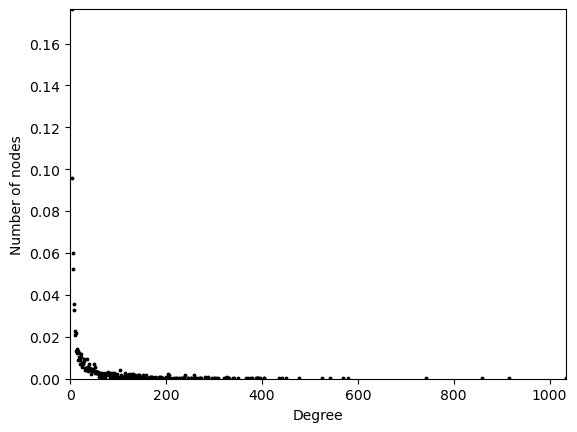

In [11]:
degs, counts = degree_distribution(G)
plt.scatter(degs, counts, c='k', s=3)
plt.xlim([0, max(degs)])
plt.ylim([0, max(counts)])
plt.xlabel("Degree")
plt.ylabel("Number of nodes")

Text(0, 0.5, 'Log number of nodes')

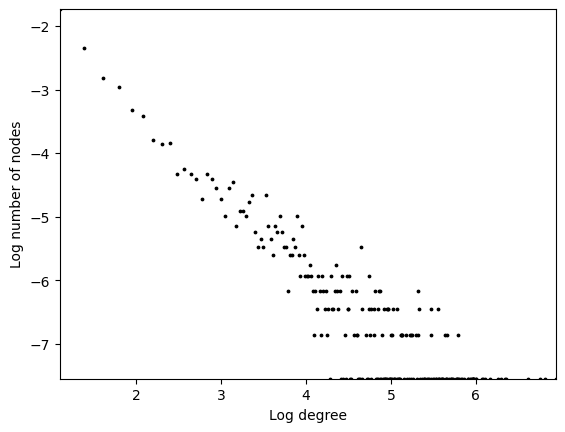

In [12]:
logdegs = np.log(degs)
logcounts = np.log(counts)

plt.scatter(logdegs, logcounts, c='k', s=3)
plt.xlim([min(logdegs), max(logdegs)])
plt.ylim([min(logcounts), max(logcounts)])
plt.xlabel("Log degree")
plt.ylabel("Log number of nodes")

In [77]:
len(G.edges)

15737

### Shrinking the Dataset

#### Helper Functions

In [13]:
def edgelist_from_community(community, edgelist):
    G = to_graph(adjacency_matrix(edgelist))
    connected_community = gcc(G.subgraph(community)).nodes
    
    cond = True
    if not SELF_LOOPS:
        cond = edgelist["from"] != edgelist["to"]
    
    community_edgelist = edgelist[edgelist["from"].isin(connected_community) & edgelist["to"].isin(connected_community) & cond]
    
    reindexed_edgelist = community_edgelist.copy()
    
    i = 0
    for node in community:
        idc_from = community_edgelist["from"] == node
        idc_to = community_edgelist["to"] == node
        edges = len(reindexed_edgelist[idc_from]) + len(reindexed_edgelist[idc_to])
        
        if edges > 0:
            reindexed_edgelist.loc[community_edgelist["from"] == node, "from"] = i
            reindexed_edgelist.loc[community_edgelist["to"] == node, "to"] = i
            i += 1

    return reindexed_edgelist

def get_communities(edgelist):
    g_full_cum = adjacency_matrix(edgelist)
    G_full_cum = to_graph(g_full_cum)
    giant_component = gcc(G_full_cum)
    
    del g_full_cum
    
    return asyn_fluidc(giant_component, N_COMMUNITIES)

def plot_communities(edgelist):
    communities = get_communities(edgelist)
    
    i = 0
    for community in communities:
        if len(community) < MAX_COMMUNITY_SIZE and i < 4:
            community_edgelist = edgelist_from_community(community, edgelist)
            g_cumulative = adjacency_matrix(community_edgelist)
            plot_from_adjacency_matrix(g_cumulative, node_size=20, layout=nx.kamada_kawai_layout)
            i += 1

    plt.show()
    
def community_adjacency_tensor(edgelist, communities):
    community = next(communities)
    
    while len(community) > MAX_COMMUNITY_SIZE:
        community = next(communities)
    
    community_edgelist = edgelist_from_community(community, edgelist)
    community_edgelist = downsample(community_edgelist)
    g_community = adjacency_tensor(community_edgelist)  
    
    return g_community

def community_adjacency_tensors(edgelist, communities, n=4):
    gs = []
    g_full_cum = adjacency_matrix(edgelist)
    communities = get_communities(g_full_cum)
    
    i = 0
    for community in communities:
        if i == n:
            break
            
        if len(community) < MAX_COMMUNITY_SIZE and i < n:
            community_edgelist = edgelist_from_community(community, edgelist)
            community_edgelist = downsample(community_edgelist)
            g_community = adjacency_tensor(community_edgelist)  
            gs.append(g_community)
            i += 1
    
    del g_full_cum
    
    return gs

def get_gen_elem(gen, index):
    return next(itertools.islice(gen, index, None))

### Baseline Models

#### Constants

In [66]:
N_TRIALS = 1
# Construct a zero matrix with trial dimension
trials_like = lambda g: torch.zeros(g.shape[0], N_TRIALS, g.shape[1], g.shape[2])

#### Models

In [15]:
class BAModel():
    
    def fit(self, g):
        T = g.shape[0]
        g_inf = trials_like(g)
        
        for t in range(T):
            G_t = g[:t+1].sum(axis=0)
            graph_t = to_graph(G_t)
            
            # BA model should only grow to the greatest connected component size of G_t
            n_nodes = len(gcc(graph_t).nodes)
            # Make sure m >= 1
            deg = int(max(mean_degree(graph_t), 1))
            # Make sure m < n
            ba_nodes = int(max(n_nodes, deg + 1))
            
            for n in range(N_TRIALS):
                ba_graph = nx.barabasi_albert_graph(
                    n=ba_nodes, 
                    m=deg, 
                    seed=SEED + n
                )

                ba_g = to_t(nx.adjacency_matrix(ba_graph).todense())

                g_inf[t,n,:ba_g.shape[0],:ba_g.shape[1]] = ba_g
        
        return g_inf

In [53]:
class AltBAModel():
    
    def simulate(self, n, m, T):
        g = torch.zeros(n, n)
        # Laplace smoothing - assume uniform and nonzero distribution over degrees
        p_k = torch.ones(n)
        
        for t in range(T):            
            for i in range(n):
                p_i = torch.clone(p_k)
                # Avoid forming self-loops
                p_k[i] = 0
                
                edge_dist = Categorical(p_i)
                
                for s in range(m):
                    j = edge_dist.sample()
                    g[i][j] += 1
            
            p_k += g.sum(axis=-1)
        
        return g
    
    def fit(self, g):
        T = g.shape[0]
        n_nodes = g.shape[-1]
        g_inf = trials_like(g)
        
        for t in range(T):
            avg_degree = int(max(1, np.mean([mean_degree(to_graph(g_s)) for g_s in g[:t+1]])))
            
            for n in range(N_TRIALS):
                g_inf[t,n,:,:] = self.simulate(
                    n=n_nodes,
                    m=avg_degree,
                    T=t
                )
                    
        return g_inf

In [17]:
class ERModel():
    
    def fit(self, g):
        T = g.shape[0]
        n_nodes = g.shape[-1]
        g_inf = trials_like(g)
        
        for t in range(T):
            G_t = g[:t+1].sum(axis=0)
            graph_t = to_graph(G_t)
            density = nx.density(graph_t)
            
            for n in range(N_TRIALS):
                er_graph = nx.erdos_renyi_graph(
                    n=n_nodes, 
                    p=nx.density(graph_t),
                    seed=SEED + n
                )

                g_inf[t,n,:,:] = to_t(nx.adjacency_matrix(er_graph).todense())
        
        return g_inf
            

### PLDS Model

#### Constants

In [48]:
PLDS_LR = 5e-4
PLDS_NEPOCHS = 1000
LATENT_DIM = 5
MC_SAMPLES = 1

#### Helper Functions

In [19]:
def make_psd(A):
    return A.T @ A + 1e-4 * torch.eye(A.shape[1]).to(device)

In [20]:
# Estimate latent posterior distribution
class CoupledEncoder(torch.nn.Module):
    
    def __init__(self, response_dim, tsteps):
        super(Encoder, self).__init__()
        
        self.tsteps = tsteps
        self.input_dim = 2 *  response_dim
        self.latent_dim = LATENT_DIM
        self.response_dim = response_dim
        
        self.hidden_dim = int(0.5 * self.input_dim + 0.5 * self.latent_dim)
        self.input_layer = torch.nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.hidden_layer = torch.nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        
        self.mu_layer = torch.nn.Linear(self.hidden_dim, self.latent_dim, bias=True)
        self.sigma_layer = torch.nn.Linear(self.hidden_dim, self.latent_dim, bias=True)
            
    # Responses should be pre-flattened along the time dimension
    def forward(self, response):      
        response_coupled = torch.zeros(self.tsteps, self.input_dim).to(device)
        response_coupled[0, :self.response_dim] = response[:self.response_dim]
        response_coupled[1:] = response.unfold(0, self.input_dim, self.response_dim)
        
        input_activation = torch.tanh(self.input_layer(response_coupled))
        hidden_activation = torch.tanh(self.hidden_layer(input_activation))
        
        mu = self.mu_layer(hidden_activation).flatten()
        # For now, assume covariance is diagonal
        sigma = self.sigma_layer(hidden_activation).flatten().diag()
        
        q = MultivariateNormal(loc=mu, covariance_matrix=make_psd(sigma))
        
        return q
    
# Estimate latent posterior distribution
class Encoder(torch.nn.Module):
    
    def __init__(self, response_dim, tsteps):
        super(Encoder, self).__init__()
        
        self.tsteps = tsteps
        self.input_dim = tsteps * LATENT_DIM
        self.output_dim = tsteps * response_dim
        self.latent_dim = LATENT_DIM
        self.response_dim = response_dim

        hidden_dim = int((self.latent_dim + response_dim) / 2)
        self.input_layer = torch.nn.Linear(response_dim, hidden_dim, bias=True)
        self.hidden_layer = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        
        self.mu_layer = torch.nn.Linear(hidden_dim, self.latent_dim, bias=True)
        self.sigma_layer = torch.nn.Linear(hidden_dim, self.latent_dim, bias=True)
    
    # Responses should be pre-flattened along the time dimension
    def forward(self, response):        
        responses = response.reshape(self.tsteps, self.response_dim)
        
        input_activation = torch.tanh(self.input_layer(responses))
        hidden_activation = torch.tanh(self.hidden_layer(input_activation))
        
        mu = self.mu_layer(hidden_activation).flatten()
        # For now, assume covariance is diagonal
        sigma = self.sigma_layer(hidden_activation).flatten().diag()
        
        q = MultivariateNormal(loc=mu.flatten(), covariance_matrix=make_psd(sigma))
        
        return q

In [21]:
# Estimate likelihood of response based on latent state
# TODO: Make responses independent w.r.t. time
class Generator(torch.nn.Module):
    
    def __init__(self, response_dim, tsteps, rate_func=torch.exp):
        super(Generator, self).__init__()
        
        self.tsteps = tsteps
        self.response_dim = response_dim
        self.latent_dim = LATENT_DIM
        
        self.rate_func = rate_func
        self.rate_estimator = torch.nn.Linear(self.latent_dim, response_dim, bias=True)
        
    def forward(self, latent_state, tsteps=None):
        T = self.tsteps
        
        if tsteps:
            T = tsteps
        
        rate = self.rate_estimator(latent_state.reshape(T, self.latent_dim))
        p = Poisson(rate=self.rate_func(rate.flatten()))
        
        return p

In [22]:
# Estimate distributions of latent states under LDS model
class AutoRegressor(torch.nn.Module):
    
    def __init__(self, tsteps):
        super(AutoRegressor, self).__init__()
        
        self.latent_dim = LATENT_DIM
        self.tsteps = tsteps
        
        self.dynamics_estimator = torch.nn.Linear(self.latent_dim, self.latent_dim, bias=True)
        self.dynamics_cov = Parameter(torch.eye((tsteps - 1) * self.latent_dim))
        
        self.initial_dynamics_mean = Parameter(torch.zeros(self.latent_dim))
        self.initial_dynamics_cov = Parameter(torch.eye(self.latent_dim))
    
    def forward(self, latent_state):
        latent_states = latent_state.reshape(self.tsteps, self.latent_dim)
        predicted_next_states = self.dynamics_estimator(latent_states)
        
        dynamics_mean = predicted_next_states[:-1].flatten()
        
        p_x = MultivariateNormal(loc=dynamics_mean, covariance_matrix=make_psd(self.dynamics_cov))
        p_x1 = MultivariateNormal(loc=self.initial_dynamics_mean, covariance_matrix=make_psd(self.initial_dynamics_cov))
        
        return p_x, p_x1
        
    
    def predict(self, x):
        p_x = MultivariateNormal(
            loc=self.dynamics_estimator(x), 
            covariance_matrix=make_psd(self.initial_dynamics_cov)
        )
        
        return p_x.sample()

In [23]:
class PLDS(torch.nn.Module):
    
    def __init__(self, 
                 num_nodes, 
                 tsteps,
                 rate_func=torch.exp
                ):
        
        super(PLDS, self).__init__()
        
        self.symmetric = not DIRECTED
        self.num_nodes = num_nodes
        
        if self.symmetric:
            self.output_dim = int((num_nodes ** 2 - num_nodes)/2) + num_nodes
        else:
            self.output_dim = num_nodes ** 2
    
        self.latent_dim = LATENT_DIM
        self.tsteps = tsteps
        self.mc_samples = MC_SAMPLES
        
        self.encoder = Encoder(
            response_dim=self.output_dim, 
            tsteps=tsteps
        )
        self.generator = Generator(
            response_dim=self.output_dim, 
            tsteps=tsteps,
            rate_func=rate_func
        )
        self.auto_regressor = AutoRegressor(
            tsteps=tsteps
        )
    
    def forward(self, g):
        g_vec = self.vectorize(g)
        response = g_vec.flatten()
        
        q = self.encoder(response)
        elbo = 0
        
        for sample in range(self.mc_samples):
            latent_state = q.rsample()
            posterior_ll = q.log_prob(latent_state).sum()
            
            p = self.generator(latent_state)
            p_x, p_x1 = self.auto_regressor(latent_state)
                
            x1 = latent_state[:self.latent_dim]  
            x = latent_state[self.latent_dim:]
            
            joint_ll = p.log_prob(response).sum() + p_x1.log_prob(x1) + p_x.log_prob(x).sum()
            
            elbo += joint_ll - posterior_ll
                
        return q, -elbo / self.mc_samples
    
    def vectorize(self, g):
        g_vec = g.flatten(start_dim=1)
        
        T = g_vec.shape[0]
        
        if self.symmetric:
            g_vec = g.triu().flatten(start_dim=1)
            g_vec = g_vec[g_vec.nonzero()]
        
        return g_vec
    
    def predict(self, g):
        g_vec = self.vectorize(g)
        response = g_vec.flatten()
        
        q = self.encoder(response)
        latent_state = q.sample()
        latent_states = latent_state.reshape(self.tsteps, self.latent_dim)
        
        p = self.generator(latent_state)
        inferred_response = p.sample()
        inferred_responses = inferred_response.reshape(self.tsteps, self.output_dim)
        
        p_x, p_x1 = self.auto_regressor(latent_state)
        
        mu_1 = p_x1.loc        
        mu = p_x.loc.reshape(self.tsteps - 1, self.latent_dim)
        expected_latent_states = torch.cat([mu_1.unsqueeze(0), mu], axis=0)
        
        if not self.symmetric:
            inferred_responses = inferred_responses.reshape(self.tsteps, self.num_nodes, self.num_nodes)
        # TODO: Reshape symmetric response
        
        return p, q, expected_latent_states, latent_states, inferred_responses
    
    def predict_trials(self, g):
        g_vec = self.vectorize(g)
        response = g_vec.flatten()
        
        all_inferred_responses = torch.zeros(N_TRIALS, g.shape[0], g.shape[1], g.shape[2])
        
        for n in range(N_TRIALS):
            q = self.encoder(response)
            latent_state = q.sample()
            latent_states = latent_state.reshape(self.tsteps, self.latent_dim)

            p = self.generator(latent_state)
            inferred_response = p.sample()
            inferred_responses = inferred_response.reshape(self.tsteps, self.output_dim)

            if not self.symmetric:
                all_inferred_responses[n] = inferred_responses.reshape(self.tsteps, self.num_nodes, self.num_nodes)
            # TODO: Reshape symmetric response
        
        # Swap trial dimension for convenience
        return all_inferred_responses.permute(1, 0, 2, 3)
    
    def unvectorize(self, responses, tsteps=None):
        if tsteps is None:
            tsteps = self.tsteps

        g = responses.reshape(tsteps, self.num_nodes, self.num_nodes)
        
        return g
    
    def predict_future(self, g, T):
        responses = self.vectorize(g)
        T0 = responses.shape[0]
        
        q = self.encoder(responses)
        latent_state = q.sample()
        x = latent_state[-self.latent_dim:]
        
        future_responses = torch.zeros(T0 + T, responses.shape[-1])
        future_responses[:T0] = responses
        
        for t in range(T):
            x = self.auto_regressor.predict(x)
            p = self.generator(x, tsteps=1)
            inferred_response = p.sample()
            future_responses[T0 + t] = inferred_response
            
        return self.unvectorize(future_responses, tsteps=T0 + T)
    
    def fit(self, g):
        optimizer = torch.optim.Adam(self.parameters(), lr=PLDS_LR)
    
        losses = []

        for epoch in range(PLDS_NEPOCHS):
            self.train()

            with torch.set_grad_enabled(True):
                optimizer.zero_grad()
                q, loss = self.forward(g)

                loss.backward()
                optimizer.step()

                losses.append(loss)

        return torch.Tensor(losses)

### Model Performance

#### Helper functions

In [24]:
def has_multiple_trials(G):
    return len(G.shape) > 2

def expectation(func, x):
    return np.mean([func(xi) for xi in x])

def mean_degree(G):
    return sum(d for n, d in G.degree()) / len(G.nodes)

def compare_network_metrics(g, g_plds, g_baseline):
    T = g.shape[0]
    ts = torch.linspace(0, T-1, T)
    n_metrics = 3
    metrics = torch.zeros(len(g_baseline) + 2, n_metrics, ts.shape[0])
    
    transitivity = lambda graph: nx.transitivity(graph)
    apl = lambda graph: nx.average_shortest_path_length(gcc(graph))
    density = lambda graph: nx.density(graph)
    
    for i, t in enumerate(ts):
        t = t.int()
        tf = t + 1

        G_true_t = g[:tf].sum(axis=0)
        G_plds_t = g_plds[:tf].sum(axis=0)
        G_ts = [G_true_t, G_plds_t]

        for g_model in g_baseline:
            G_ts.append(g_model[t])

        for j, G_t in enumerate(G_ts):
            
            if has_multiple_trials(G_t):
                # Convert each trial's adjacency matrix to a graph
                graphs_t = [to_graph(G_ti) for G_ti in G_t]
                # Take expectation of metrics over trials
                metrics[j, 0, i] = expectation(transitivity, graphs_t)
                metrics[j, 1, i] = expectation(apl, graphs_t)
                metrics[j, 2, i] = expectation(density, graphs_t)
            else:
                graph_t = to_graph(G_t)
                metrics[j, 0, i] = transitivity(graph_t)
                metrics[j, 1, i] = apl(graph_t)
                metrics[j, 2, i] = density(graph_t)
    
    return ts, metrics

In [59]:
colors = ['k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

def plot_network_metrics(ts, metrics, labels, metric_labels, show_models=None):
    n_models, n_metrics = metrics.shape[:-1] 
    
    fig, axs = plt.subplots(n_metrics, 1, figsize=(10,20))

    if not show_models:
        show_models = [True] * n_models
    
    for j in range(n_metrics):
        for i in range(n_models):
            if show_models[i]:
                lstyle = '--'

                if i == 0:
                    lstyle = '-'

                axs[j].plot(ts, metrics[i,j], label=labels[i], color=colors[i], linestyle=lstyle)
        
        axs[j].set_ylabel(metric_labels[j])
        axs[j].set_xlabel("Time")
        axs[j].legend()
        
def compare_degree_distributions(g, g_plds, g_baseline, labels):
    G_true = g.sum(axis=0)
    G_plds = g_plds.sum(axis=0)
    Gs = [G_true, G_plds]
        
    for g_model in g_baseline:
        Gs.append(g_model[-1])
    
    fig, axs = plt.subplots(len(Gs), 1, figsize=(10,20))
    
    all_degrees = []
    all_counts = []
    max_degree = 0
    max_count = 0
    
    for i, G in enumerate(Gs):
        degrees, counts = [], []
        multi_trials = has_multiple_trials(G)
        
        if multi_trials:
            for n in range(G.shape[0]):
                degrees_n, counts_n = degree_distribution(to_graph(G[n])) 
                degrees.append(degrees_n)
                counts.append(counts_n)
        else:
            degrees, counts = degree_distribution(to_graph(G))
        
        max_degree_i = 0
        max_count_i = 0
        
        if multi_trials:
            max_degree_i = max([max(degrees_n) for degrees_n in degrees])
            max_count_i = max([max(counts_n) for counts_n in counts])
        else:
            max_degree_i = max(degrees)
            max_count_i = max(counts)

        all_degrees.append(degrees)
        all_counts.append(counts)
        
        max_degree = int(max(max_degree, max_degree_i))
        max_count = max(max_count, max_count_i)
        
    for i, G in enumerate(Gs):
        degrees = torch.arange(0, max_degree + 1)
        counts = torch.zeros(max_degree + 1)
        
        if has_multiple_trials(G):
            # If there are multiple trials, find expected distribution
            for degrees_n, counts_n in zip(all_degrees[i], all_counts[i]):
                for degree, count in zip(degrees_n, counts_n):
                    counts[int(degree)] += count
                    
            counts /= N_TRIALS
        else:
            degrees = all_degrees[i]
            counts = all_counts[i]
        
        axs[i].plot(degrees, counts, color=colors[i], linestyle='--')
        axs[i].scatter(degrees, counts, c=colors[i], label=labels[i])
        axs[i].legend()
        axs[i].set_xlabel("Degree")
        axs[i].set_ylabel("Frequency")
        axs[i].set_xlim([0, max_degree])
        axs[i].set_ylim([0, max_count + 0.1])
             
def centrality_mse(G_true, G_inf):
    true_centrality = nx.eigenvector_centrality_numpy(G_true, weight="weight").values()
    inf_centrality = nx.eigenvector_centrality_numpy(G_inf, weight="weight").values()
    
    return np.mean([(c_true - c_inf) ** 2 for c_true, c_inf in zip(true_centrality, inf_centrality)])
        
def compare_centrality_preservation(g, g_plds, g_baseline, labels):
    G_true = g.sum(axis=0)
    graph_true = to_graph(G_true)
    
    G_plds = g_plds.sum(axis=0)
    Gs = [G_plds]
        
    for g_model in g_baseline:
        Gs.append(g_model[-1])
        
    errors = []
    
    centrality_err = lambda G: centrality_mse(graph_true, to_graph(G))
    
    for i, G in enumerate(Gs):
        errors.append(expectation(centrality_err, G))
            
    plt.bar(labels, errors, color=colors[1:len(labels)+1])
    plt.ylabel("Centrality MSE")

#### Community-Level Measures

In [26]:
communities = get_communities(edgelist)
g = community_adjacency_tensor(edgelist, communities)

In [28]:
G_community = to_graph(g.sum(axis=0))

In [29]:
print("Transitivity:", nx.transitivity(G_community))
print("APL:", nx.average_shortest_path_length(gcc(G_community)))
print("Density", nx.density(G_community))
print("Diameter:", nx.diameter(gcc(G_community)))

Transitivity: 0.09763313609467456
APL: 3.2967032967032965
Density 0.03774486383182035
Diameter 7


Text(0, 0.5, 'Frequency')

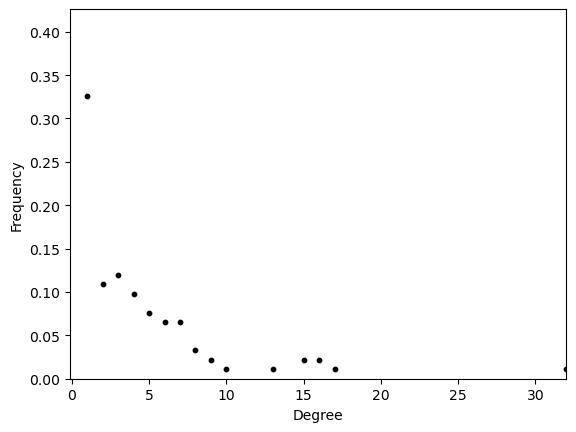

In [42]:
degs, counts = degree_distribution(G_community)
plt.scatter(degs, counts, c='k', s=10)
plt.xlim([-0.1, max(degs)])
plt.ylim([0, max(counts)+0.1])
plt.xlabel("Degree")
plt.ylabel("Frequency")

Text(0, 0.5, 'Log frequency')

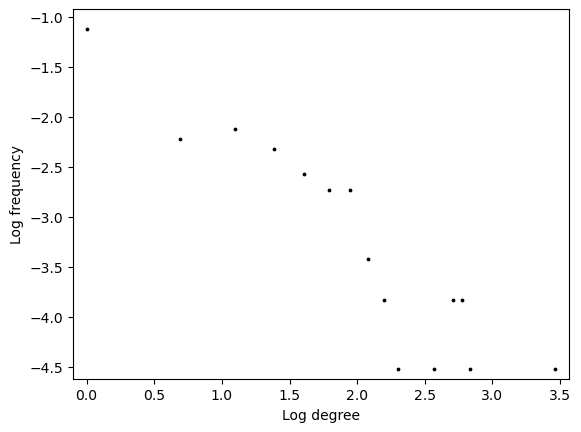

In [46]:
logdegs = np.log(degs)
logcounts = np.log(counts)

plt.scatter(logdegs, logcounts, c='k', s=3)
plt.xlim([min(logdegs)-0.1, max(logdegs)+0.1])
plt.ylim([min(logcounts)-0.1, max(logcounts)+0.2])
plt.xlabel("Log degree")
plt.ylabel("Log frequency")

#### Predictions

In [ ]:
try:
    del plds
except:
    pass

In [49]:
plds = PLDS(
    num_nodes = g.shape[-1],
    tsteps = g.shape[0],
).to(device)

elbo = plds.fit(g)

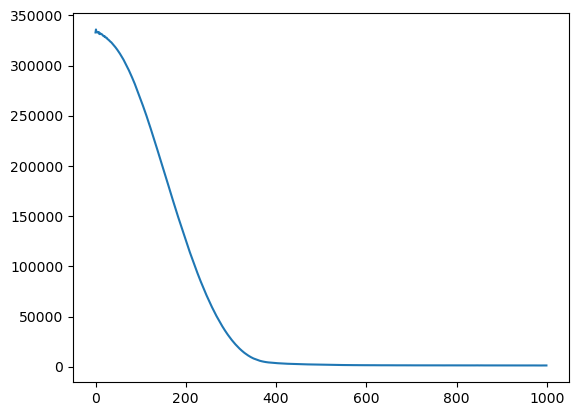

In [50]:
plt.plot(from_t(torch.Tensor(elbo)))

In [67]:
g_plds = plds.predict_trials(g)

In [68]:
ba_model = BAModel()
alt_ba_model = AltBAModel()
er_model = ERModel()

g_ba = ba_model.fit(g)
g_alt_ba = alt_ba_model.fit(g)
g_rand = er_model.fit(g)

In [69]:
model_labels = ["True", "PLDS", "BA", "Random Graph"]
baseline_models = [g_ba, g_rand]

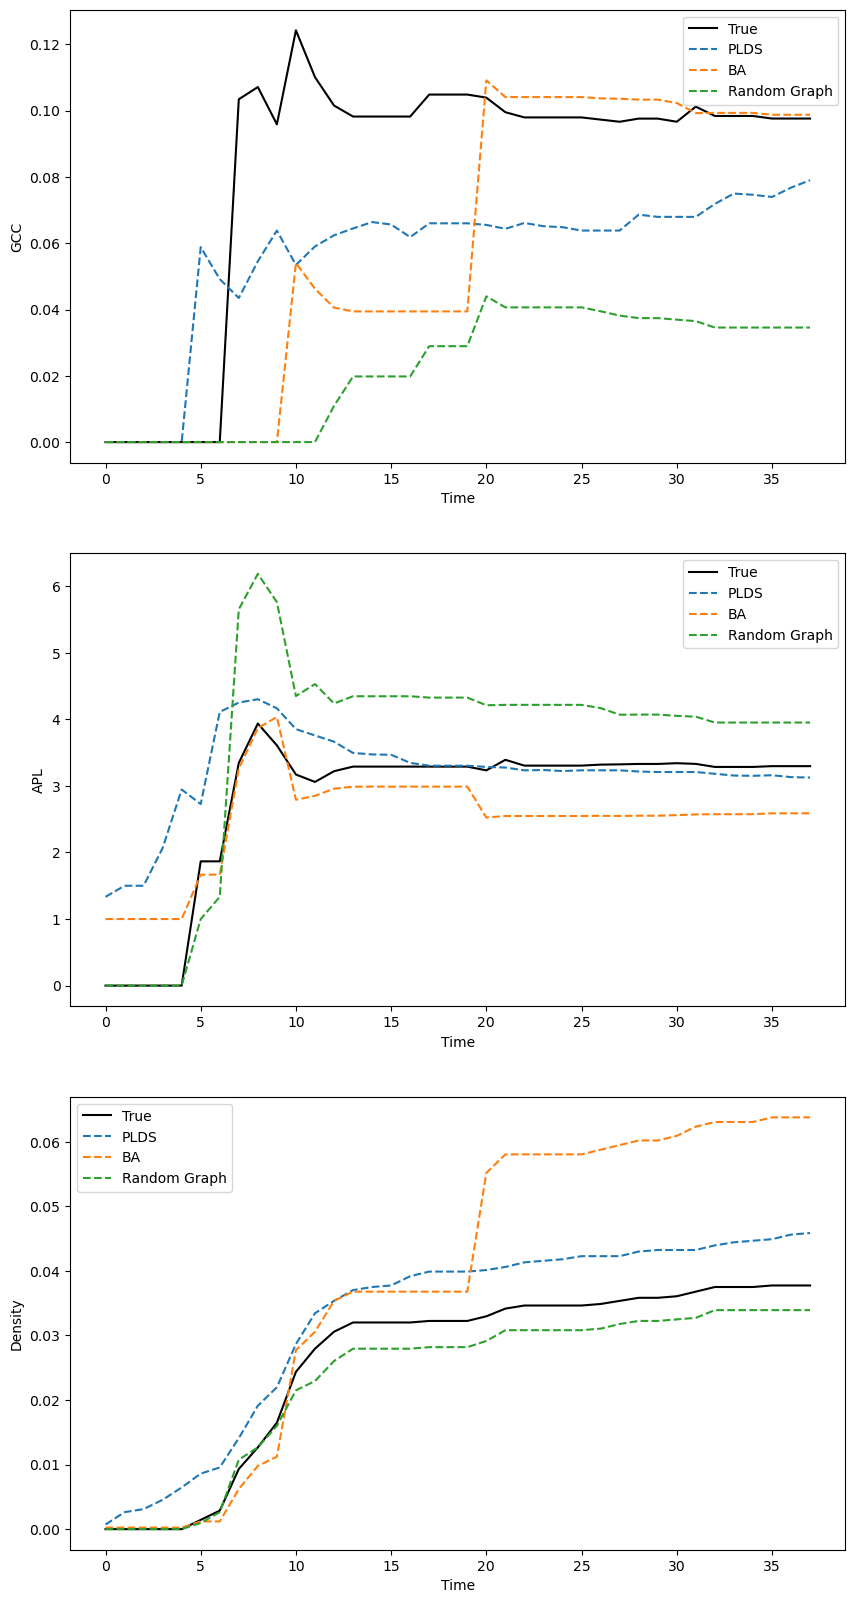

In [70]:
ts, metrics = compare_network_metrics(g, g_plds, baseline_models)
plot_network_metrics(
    ts, 
    metrics, 
    labels=model_labels, 
    metric_labels=["GCC", "APL", "Density"]
)

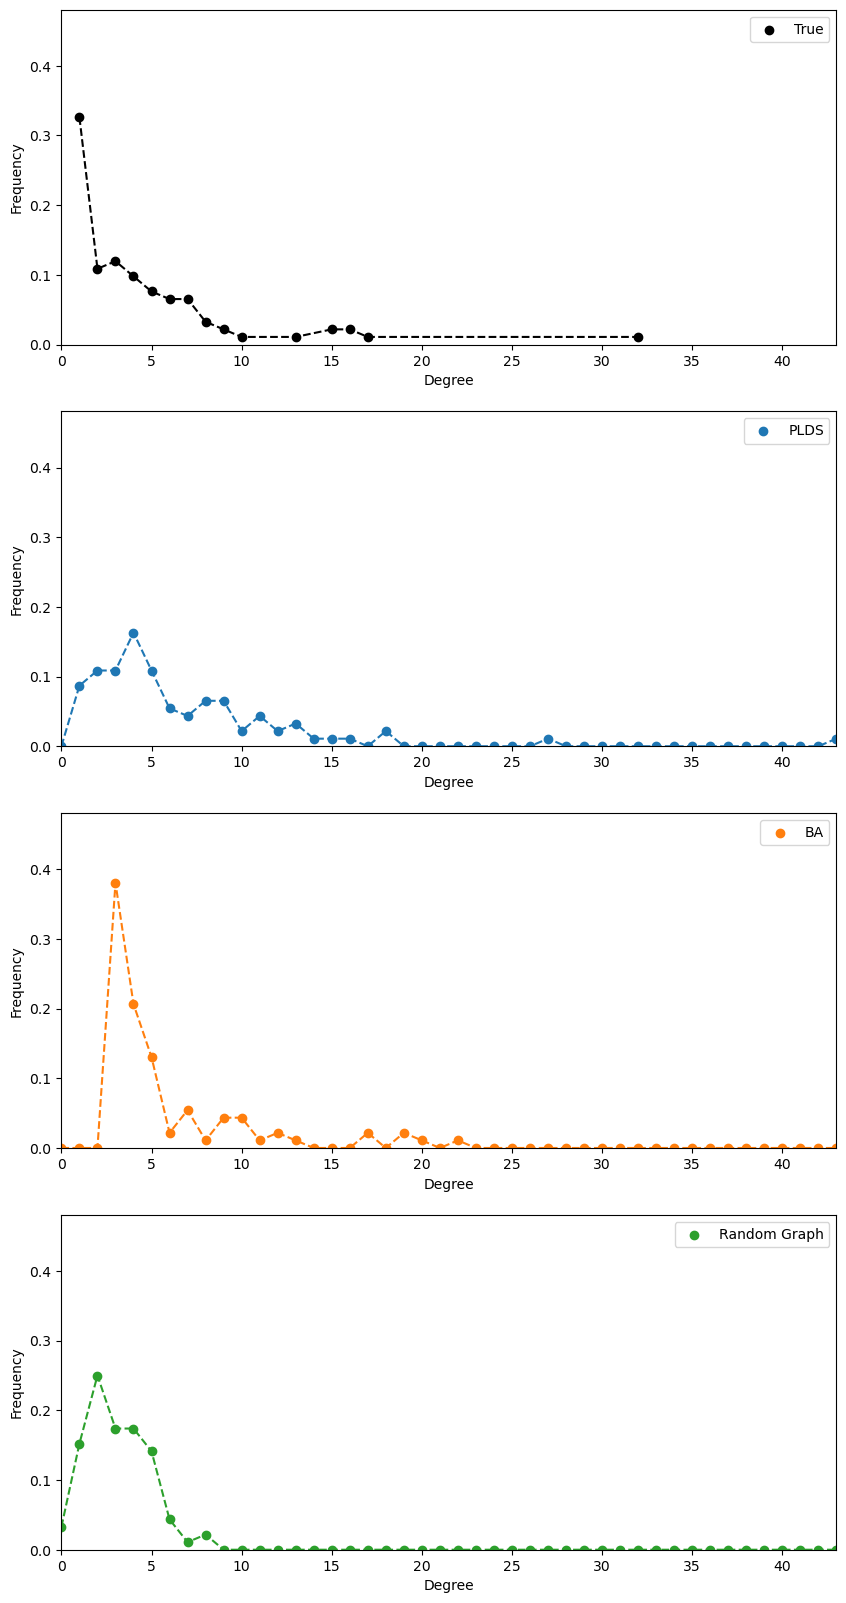

In [75]:
compare_degree_distributions(g, g_plds, baseline_models, model_labels)

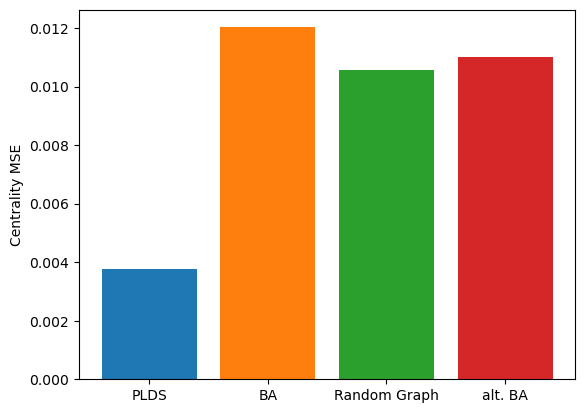

In [65]:
compare_centrality_preservation(g, g_plds, baseline_models, model_labels[1:])

In [ ]:
g_inf_cum = g_inf.sum(axis=0)
g_cum = g.sum(axis=0)

In [ ]:
plot_from_adjacency_matrix(g_inf_cum, node_size=10, layout=nx.kamada_kawai_layout)

In [ ]:
plot_from_adjacency_matrix(g_cum, node_size=15, layout=nx.kamada_kawai_layout)

In [ ]:
T_future = 20
g_dynamic_inf = model.predict_future(g, T_future)

In [ ]:
downsample = 4
ts = torch.linspace(g.shape[0], g.shape[0] + T_future, int(T_future/downsample))

for i, t in enumerate(ts):
    g_dynamic_inf_cum = g_dynamic_inf[:int(t)].sum(axis=0)
    plot_from_adjacency_matrix(g_dynamic_inf_cum, node_size=15, layout=nx.kamada_kawai_layout)

In [76]:
len(G_community.edges)

158

In [72]:
_, _, e_x, x, _ = plds.predict(g)

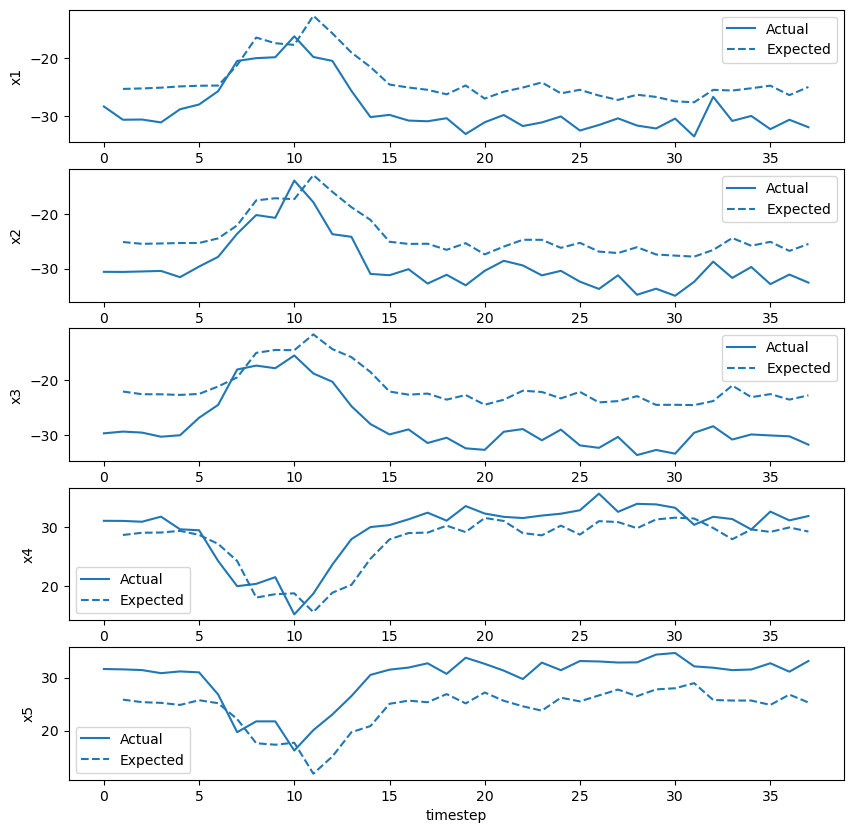

In [73]:
T, latent_dim = x.shape
fig, axs = plt.subplots(latent_dim, 1, figsize=(10,10))
t = np.arange(0, T)

for i in range(latent_dim):
    axs[i].plot(t, from_t(x[:,i]), color="tab:blue", label="Actual")
    axs[i].plot(t[1:], from_t(e_x[1:, i]), linestyle="--", color="tab:blue", label="Expected")
    axs[i].set_xlabel("timestep")
    axs[i].set_ylabel(f"x{i+1}")
    axs[i].legend()

# segs = np.concatenate([latent_curve[:-1],latent_curve[1:]], axis=1)
# print(x.shape, segs.shape)
# lc = mpl.collections.LineCollection(segs, cmap=plt.get_cmap('jet'))
# lc.set_array(t)

# ax.add_collection(lc)
# plt.show()

# plot = ax.scatter(*latent_curve, c=t, cmap="inferno")
# ax.plot(*latent_curve, color='black', alpha=0.5, linestyle='--')
# ax.set_xlabel("Latent state 1")
# ax.set_ylabel("Latent state 2")
# ax.set_zlabel("Latent state 3")
# cbar = fig.colorbar(plot, shrink=0.5, pad=0.1)
# cbar.set_label("Time")
# plt.show()

In [ ]:
print(((x - e_x)**2)[1:].mean())

In [ ]:
n = g.shape[-1]
T = g.shape[0]

rates = p.rate.reshape(T, n, n)

In [ ]:
plt.imshow(from_t(rates[-1]))

In [ ]:
plt.plot(from_t(rates.sum(axis=-1).sum(axis=-1)))
plt.plot(from_t(g.sum(axis=-1).sum(axis=-1)))

In [ ]:
full_g = adjacency_matrix(edgelist)
G = gcc(to_graph(full_g))
k = 10
communities = asyn_fluidc(G, k)
N = 4
first = next(communities)

In [ ]:
# plt.figure()
# subgraph = gcc(G.subgraph(community))
# pos = nx.spring_layout(subgraph)
# nx.draw(subgraph, pos=pos, node_size=10)

community_edgelist = edgelist_from_community(first, edgelist)

In [ ]:
g = adjacency_matrix(community_edgelist)
graph_g = to_graph(g)

In [ ]:
nx.adjacency_matrix(graph_g).todense().shape